In [21]:
from ift6758.data import get_wandb_data
import pandas as pd
import wandb
from sklearn.metrics import confusion_matrix
import ift6758.visualizations.debugging_tool as debugging_tool
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
LOG = False

In [22]:
artifact_name = "train_val_feature_eng_1"
get_wandb_data.download_artifact(artifact_name=artifact_name, artifact_version="v3")
df = get_wandb_data.load_all_files_from_artifact(artifact_name=artifact_name)
df

wandb:   4 of 4 files downloaded.  


Artifact downloaded to: ../ift6758/data/wandb_artifacts//train_val_feature_eng_1


,season,game_id,event_id,angle_from_net,is_goal,empty_net,distance_from_net
0,20162017,2016020001,8,22.619865,0,0,13.000000
1,20162017,2016020001,11,77.005383,0,0,13.341664
2,20162017,2016020001,15,29.931512,0,0,76.157731
3,20162017,2016020001,16,14.995079,0,0,57.974132
4,20162017,2016020001,24,26.980231,0,0,61.717096
...,...,...,...,...,...,...,...
305809,20192020,2019021082,773,62.447188,0,0,25.942244
305810,20192020,2019021082,774,71.113913,0,0,40.162171
305811,20192020,2019021082,537,45.000000,0,0,14.142136
305812,20192020,2019021082,777,41.185925,0,0,10.630146


In [23]:
#TODO: remove NaN values at preprocess stage
def check_nan_values(df):
    nan_distance = df['distance_from_net'].isna().sum()
    nan_angle = df['angle_from_net'].isna().sum()
    print(f"Number of NaN values in distance_from_net: {nan_distance}")
    print(f"Number of NaN values in angle_from_net: {nan_angle}")
check_nan_values(df)

Number of NaN values in distance_from_net: 17
Number of NaN values in angle_from_net: 17


In [24]:
df = df.dropna(subset=['angle_from_net', 'distance_from_net'])


In [25]:
check_nan_values(df)

Number of NaN values in distance_from_net: 0
Number of NaN values in angle_from_net: 0


# q1

In [37]:
# Initialize and train the logistic regression model
def train_logistic_regression_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_discrete = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_val, y_pred_discrete)
    print(f'Accuracy: {accuracy}')
    return y_pred_discrete, y_pred_proba


notice accuracy high but model only predicts the events are non-goals because there are more non-goal events than goals events
so the model hasn't learnt anything

In [27]:
def plot_confusion_matrix(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Goal', 'Goal'], yticklabels=['Not Goal', 'Goal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [28]:
# Log the confusion matrix
if LOG:
    with wandb.init(name="feature_eng1_logistic_regression_logs", project="IFT6758-2024-B05", job_type="model-evaluation"):


        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_val.flatten().tolist(),
                                                                preds=y_pred.flatten().tolist(),
                                                                class_names=["Not Goal", "Goal"])})
        
        # Log the model parameters
        wandb.config.update({
            "model_type": "LogisticRegression",
            "test_size": 0.2,
            "random_state": 42
        })

        # Log the accuracy
        wandb.log({"accuracy": accuracy})
    

In [29]:
debugging_tool.display_game_id("2019020873")

id 2019020873
date 2020-02-11
Venue Location:  Dallas
Home Team:  Stars
Away Team: Hurricanes



Text(value='0', description='Event no:')

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_val, y_pred):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred[:, 1])

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(y_val, y_pred[:, 1])


    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [51]:
import numpy as np
import pandas as pd

def plot_goal_rate_by_percentile(y_pred, y_val):
    # Calculate the percentiles of the predicted probabilities
    percentiles = np.percentile(y_pred[:, 1], np.arange(0, 101, 1))


    # Create a DataFrame with the actual values and predicted probabilities
    df_percentiles = pd.DataFrame({'Actual': y_val.flatten(), 'Predicted_Prob': y_pred[:, 1]})

    
    # Remove duplicates from percentiles
    percentiles = np.unique(percentiles)

    # Assign each predicted probability to a percentile group
    # df_percentiles['Percentile'] = pd.cut(df_percentiles['Predicted_Prob'], bins=percentiles, labels=np.arange(1, 101, 1), include_lowest=True, duplicates='drop')
    df_percentiles['Percentile'] = pd.cut(df_percentiles['Predicted_Prob'], bins=percentiles, labels=np.arange(1, len(percentiles)), include_lowest=True)


    # Calculate the goal rate for each percentile group
    goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
    # goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()

    goal_rate_by_percentile
    goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()

    # Plot the goal rate as a function of the shot probability model percentile
    plt.figure(figsize=(10, 6))
    goal_rate_by_percentile.plot(kind='line')
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Goal Rate')
    plt.title('Goal Rate as a Function of Shot Probability Model Percentile')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    return df_percentiles


In [32]:
def plot_cumulative_proportion_of_goals(df_percentiles):
    # Calculate the cumulative sum of goals for each percentile
    cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()

    # Calculate the cumulative proportion of goals
    cumulative_proportion_goals = cumulative_goals / cumulative_goals.iloc[-1]

    # Plot the cumulative proportion of goals as a function of the shot probability model percentile
    plt.figure(figsize=(10, 6))
    cumulative_proportion_goals.plot(kind='line')
    plt.gca().invert_xaxis()
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Cumulative Proportion of Goals')
    plt.title('Question c')
    plt.grid(True)
    plt.show()

In [33]:
from sklearn.calibration import CalibrationDisplay

def plot_calibration_curve(y_val, y_pred):
    # Create the reliability diagram (calibration curve)
    CalibrationDisplay.from_predictions(y_val, y_pred[:, 1], n_bins=10)

    # Add labels and title
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.show()



In [52]:
def produce_figures(y_pred_proba, y_pred_discrete, y_true):

    # 0. Confusion matrix
    plot_confusion_matrix(y_true, y_pred_discrete)

    # a. ROC curve
    plot_roc_curve(y_true, y_pred_proba)

    # b. Goal Rate as a Function of Shot Probability Model Percentile
    df_percentiles = plot_goal_rate_by_percentile(y_pred_proba, y_true)

    # c. cumulative proportion of goals (not shots) as a function of the shot probability model percentile.
    plot_cumulative_proportion_of_goals(df_percentiles)

    # d. Calibration curve
    plot_calibration_curve(y_true, y_pred_proba)

In [48]:
# Define features and target variable
X = df['distance_from_net'].to_numpy().reshape(-1, 1)
y = df['is_goal'].to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_distance_discrete, y_pred_distance_proba = train_logistic_regression_model(X_train, y_train, X_val, y_val)


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


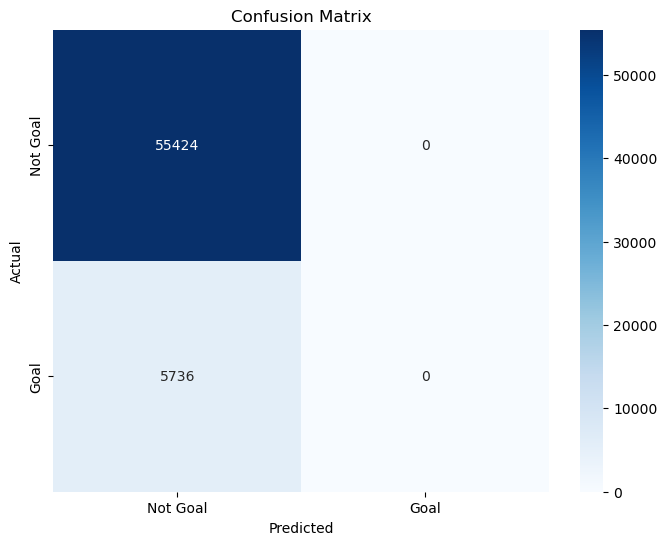

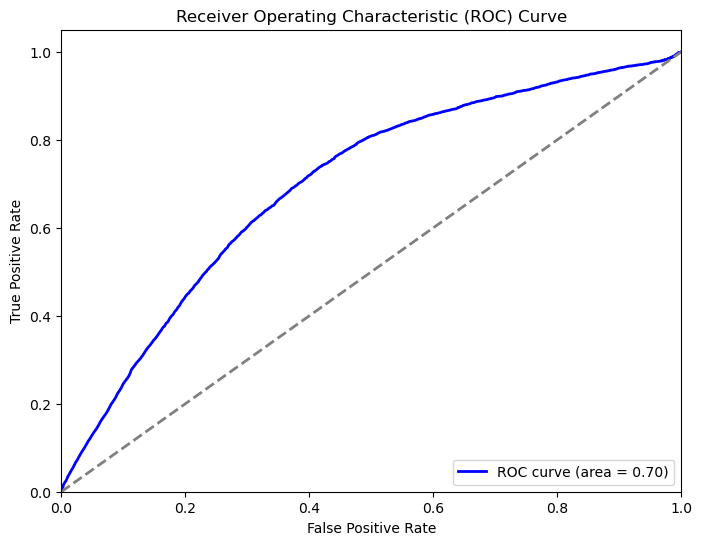

C:\Users\dre\AppData\Local\Temp\ipykernel_61708\864608237.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
C:\Users\dre\AppData\Local\Temp\ipykernel_61708\864608237.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


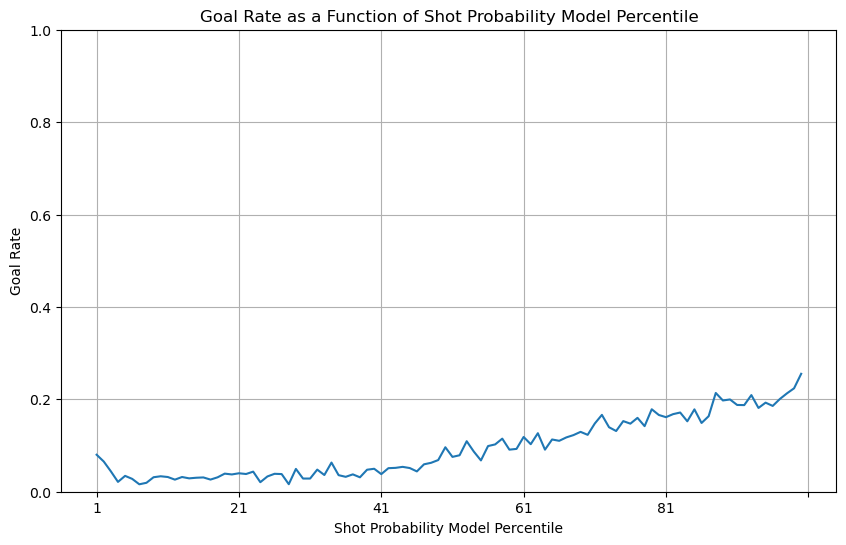

C:\Users\dre\AppData\Local\Temp\ipykernel_61708\649131311.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


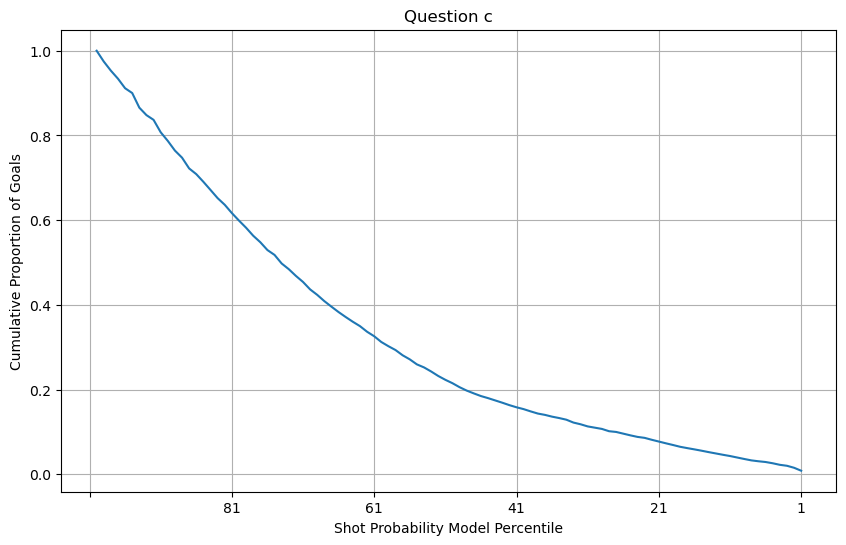

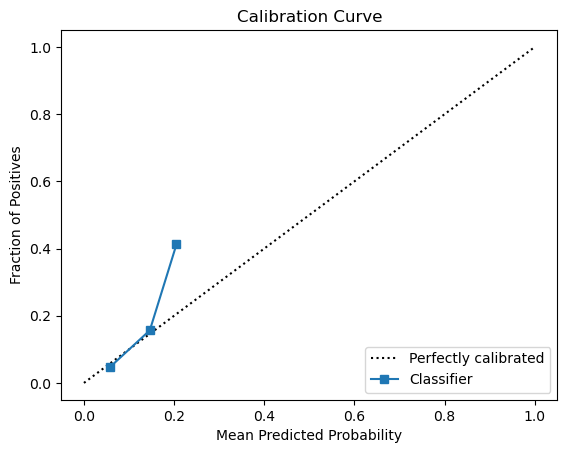

In [49]:
produce_figures(y_pred_distance_proba, y_pred_distance_discrete, y_val)

c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


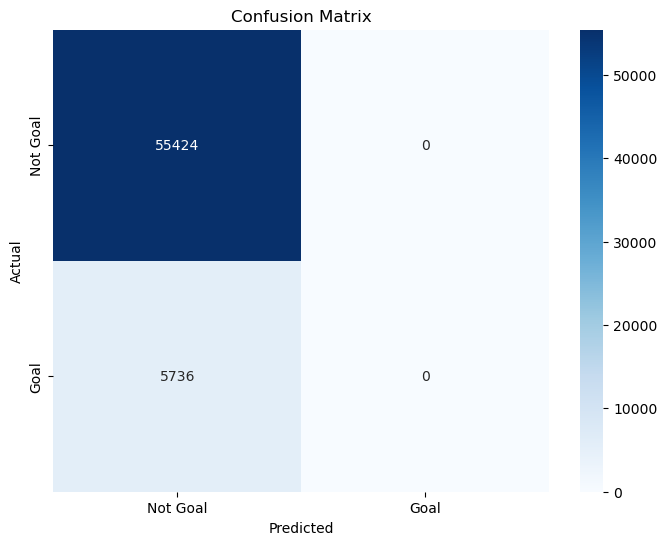

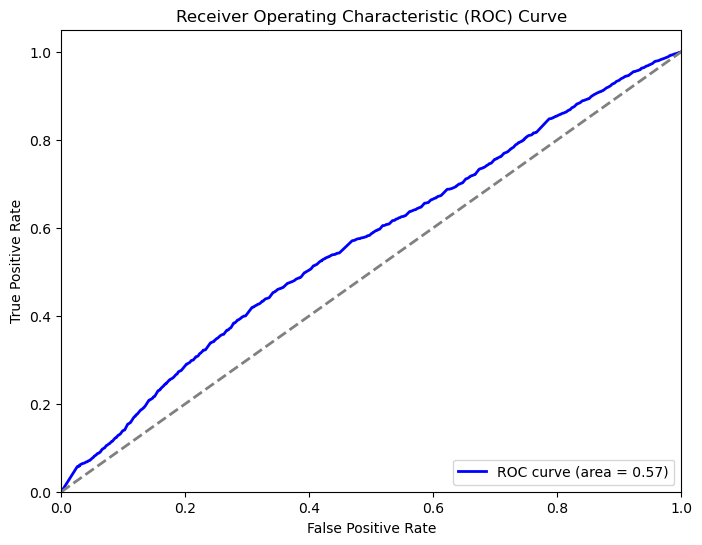

C:\Users\dre\AppData\Local\Temp\ipykernel_61708\3271916493.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
C:\Users\dre\AppData\Local\Temp\ipykernel_61708\3271916493.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


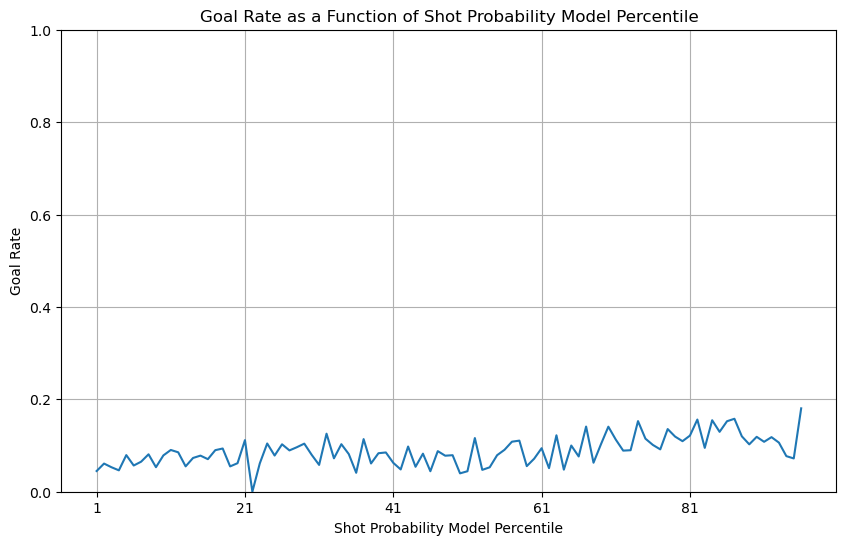

C:\Users\dre\AppData\Local\Temp\ipykernel_61708\649131311.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


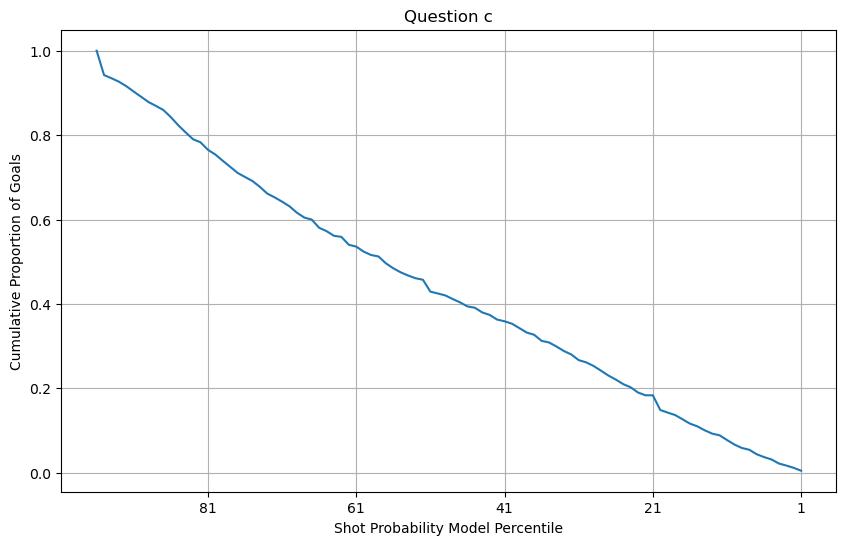

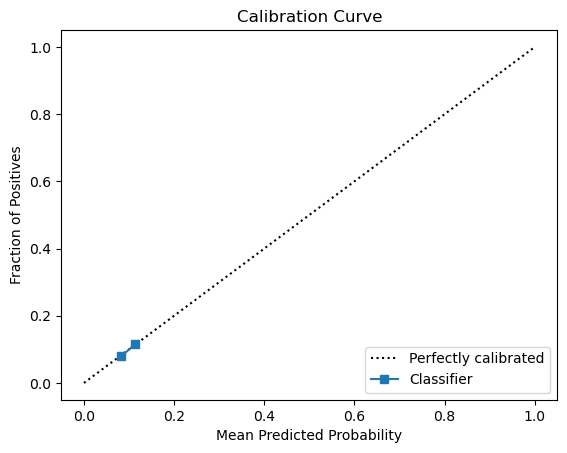

In [55]:
# Define features and target variable
X_angle = df['angle_from_net'].to_numpy().reshape(-1, 1)
y = df['is_goal'].to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
X_train_angle, X_val_angle, y_train, y_val = train_test_split(X_angle, y, test_size=0.2, random_state=42)

# Train the logistic regression model
y_pred_discrete_angle, y_pred_proba_angle = train_logistic_regression_model(X_train_angle, y_train, X_val_angle, y_val)

# Produce figures
produce_figures(y_pred_proba_angle, y_pred_discrete_angle, y_val)


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


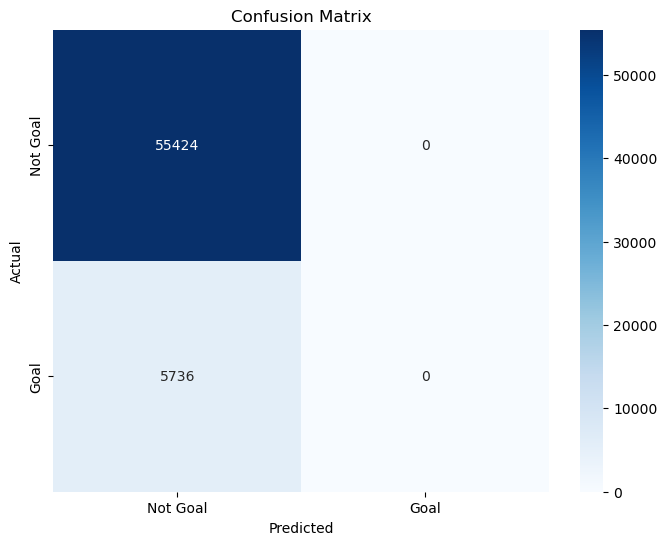

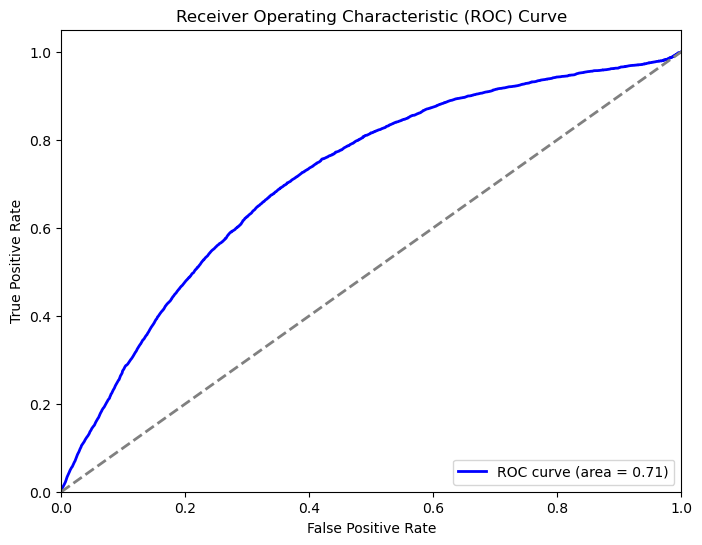

C:\Users\dre\AppData\Local\Temp\ipykernel_61708\3271916493.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
C:\Users\dre\AppData\Local\Temp\ipykernel_61708\3271916493.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


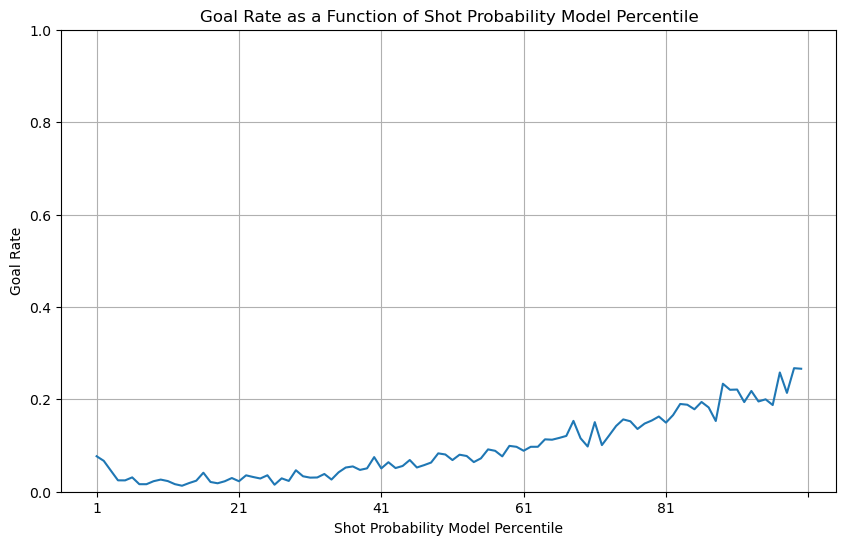

C:\Users\dre\AppData\Local\Temp\ipykernel_61708\649131311.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


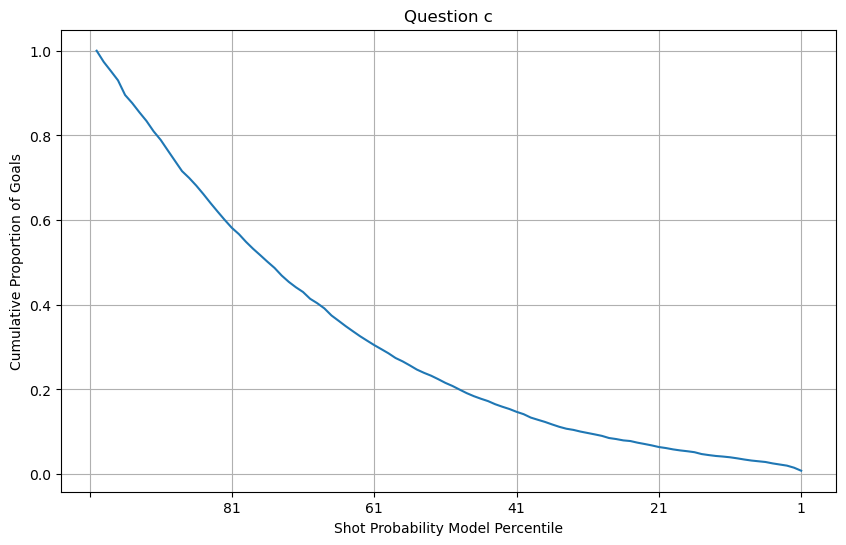

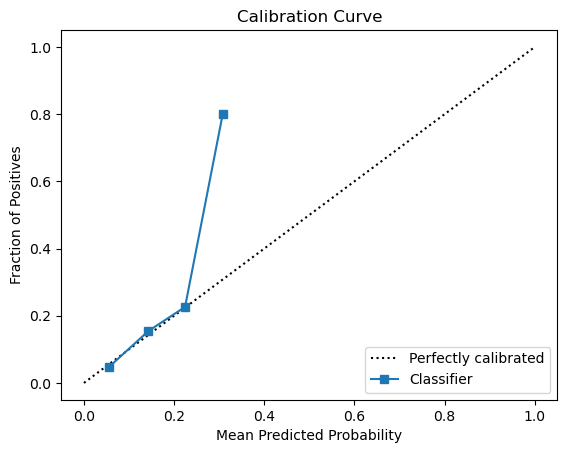

In [56]:
X_distance_angle = df[['distance_from_net', 'angle_from_net']].to_numpy()
X_train_distance_angle, X_val_distance_angle, y_train, y_val = train_test_split(X_distance_angle, y, test_size=0.2, random_state=42)
y_pred_discrete_distance_angle, y_pred_proba_distance_angle = train_logistic_regression_model(X_train_distance_angle, y_train, X_val_distance_angle, y_val)
produce_figures(y_pred_proba_distance_angle, y_pred_discrete_distance_angle, y_val)